# Short Assignment 4

This is an individual assignment. 

**Due: Thursday, March 3 @ 11:59PM**

# Problem 1

**Solve this problem on paper.**

Suppose you have the following training data set:

$$X=\{(1,1,2),(10,3,0),(-5,-4,1),(2,-3,1),(10,10,20),(0,0,0)\}$$

with training labels

$$y=\{-1,1,1,-1,-1,1\}$$

where $y_i=1$ indicates a true target and $y_i=-1$ indicates a non-target data point. Suppose you trained a $k$-NN classifier to produce a confidence of target given a sample. For the above data points, your $k$-NN produced the following confidence values:

$$c=\{0.7,0.6,0.2,0.3,0,0.9\}$$

Answer the following questions:

1. Draw the associated ROC curve.

2. To make a final decision, suppose your threshold is $c=0.5$ (confidence value), where samples with confidence values $\leq 0.5$ are marked as non-target and samples with confidence values $>0.5$ are marked as target. What would be your resulting confusion matrix, FPR and TPR?

In [1]:
from IPython.display import Image

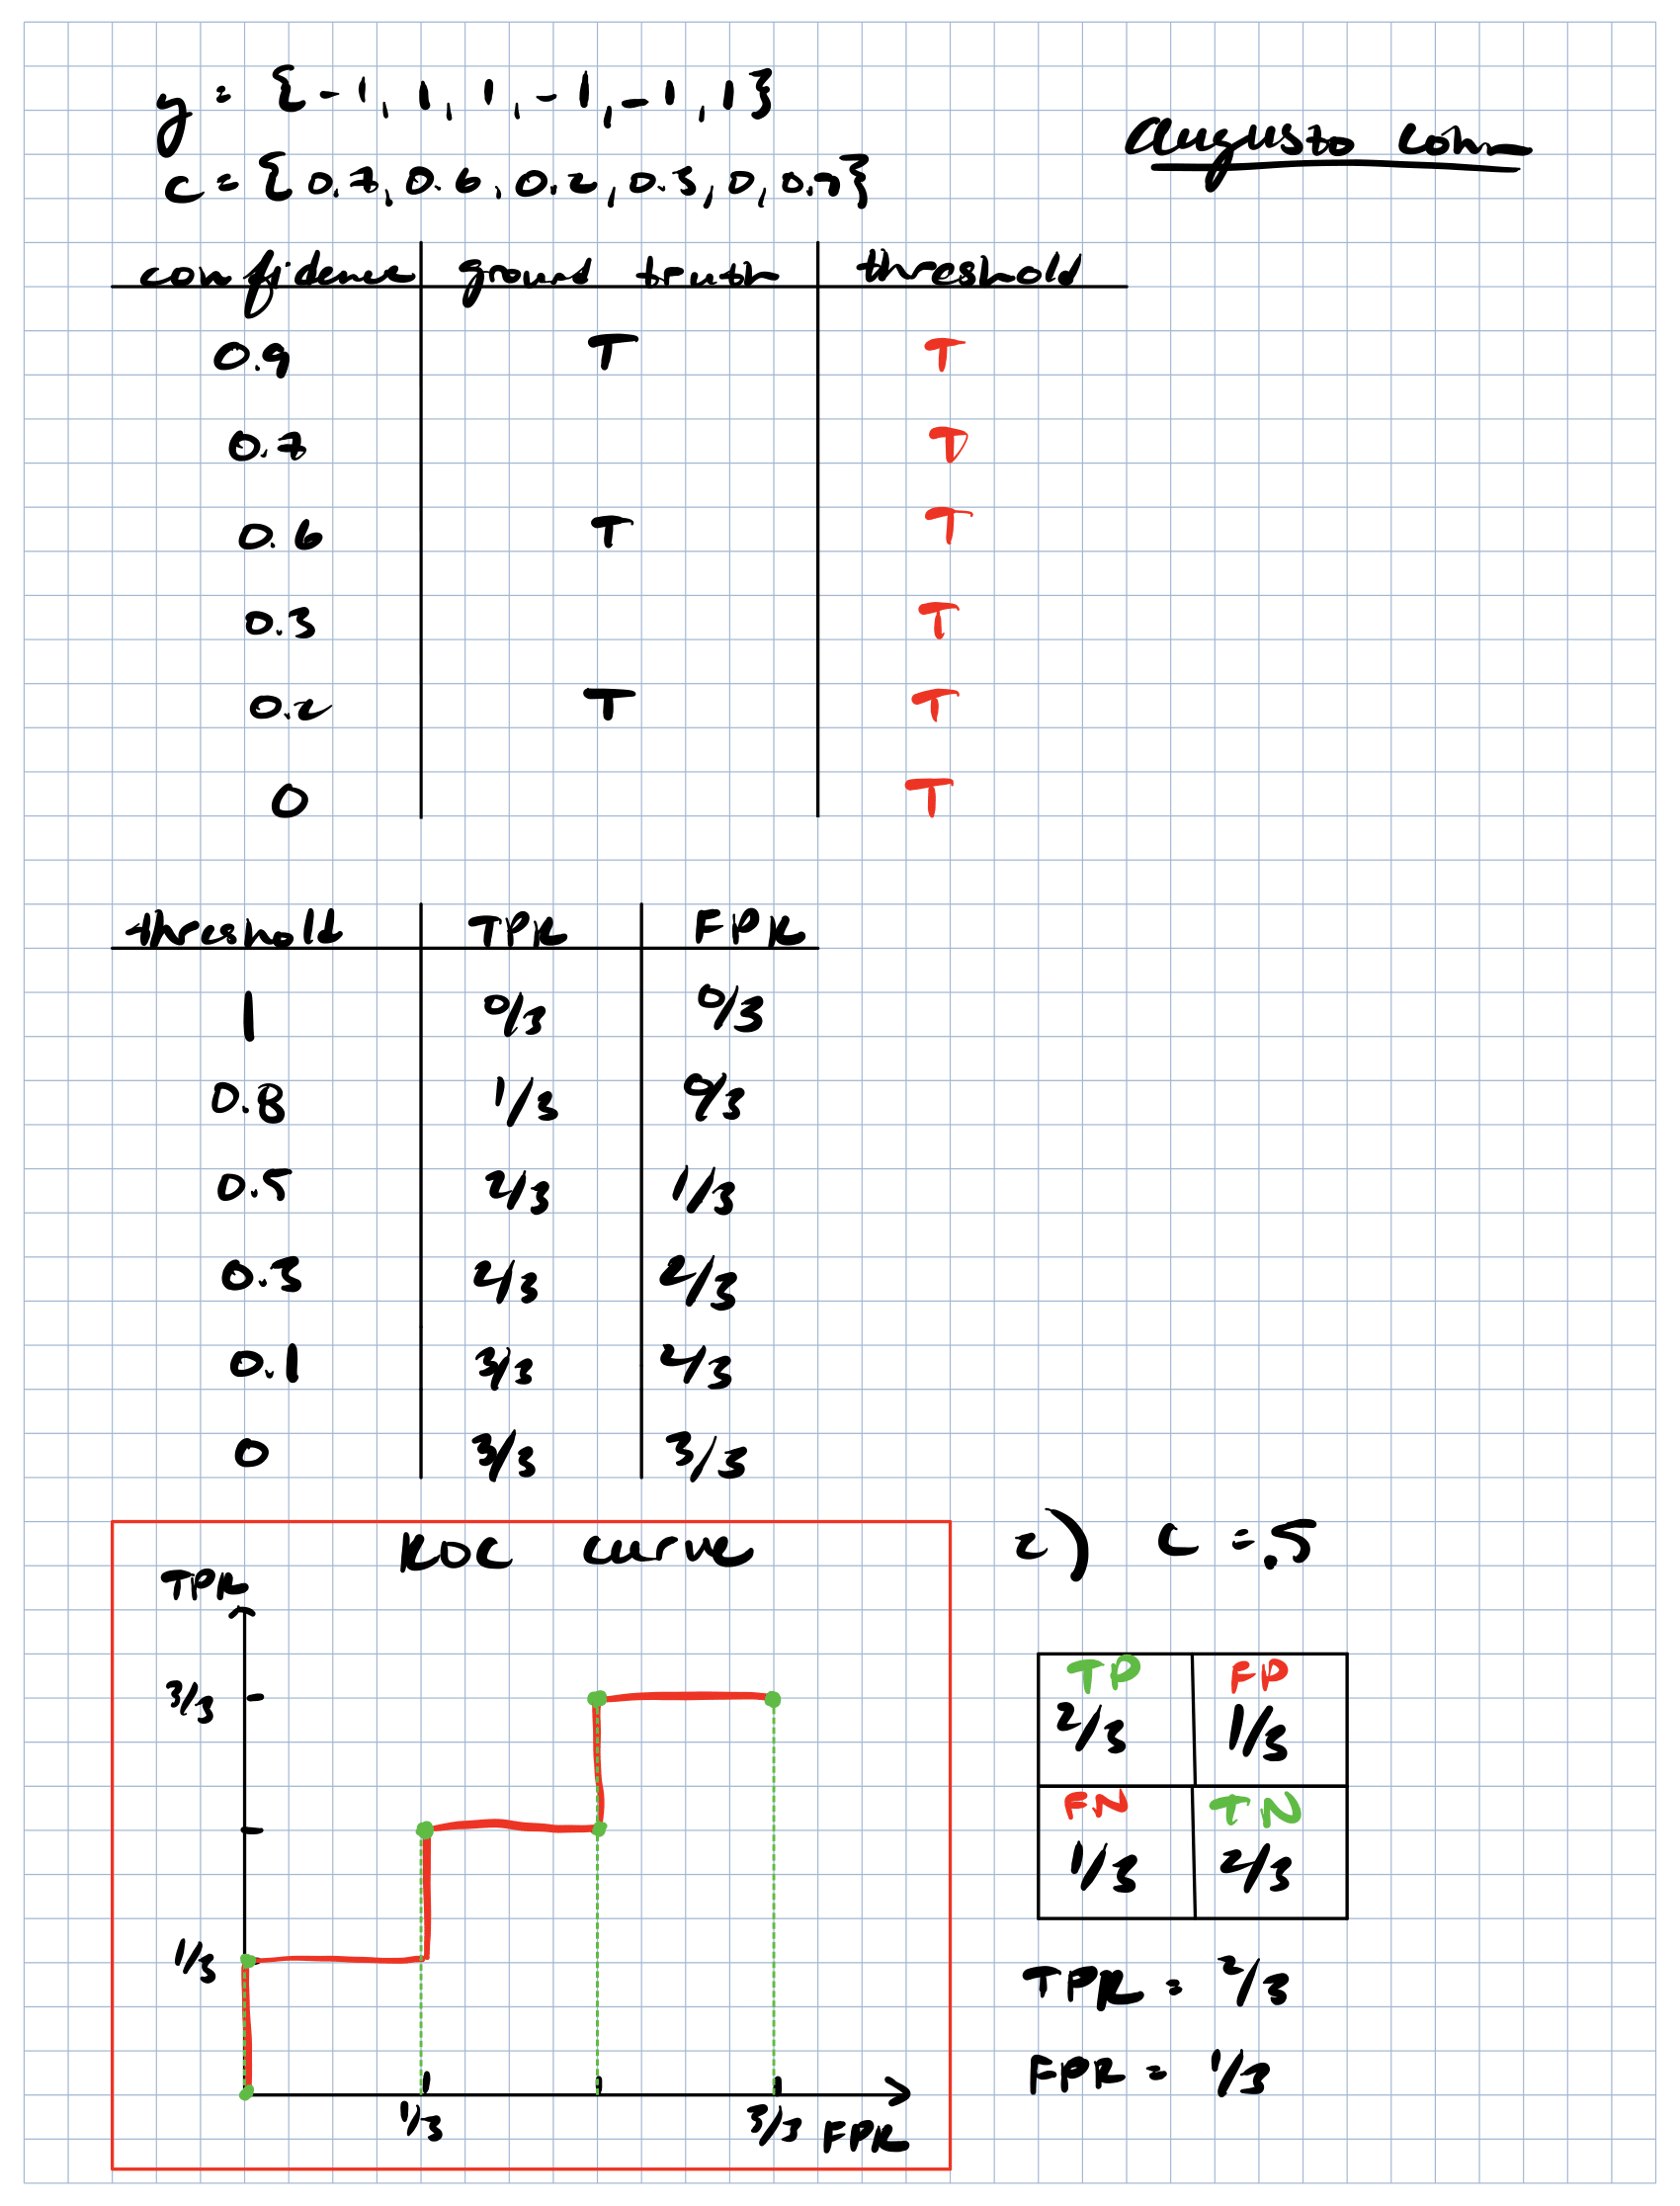

In [2]:
Image("figures/SA4.png", width=700)

NOTE: The numbers in the confusion matrix are supposed to just be the numbers, not the rates. So going from left to right, the numbers are supposed to be 2,1,1,2.

# Problem 2

The starter code below is an incomplete implementation of the EM algorithm to optimize a Gaussian Mixture Model data likelihood.

In this problem, you will complete the provided code by filling in the empty slots (do not use any library or online implementations).

In [3]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def EM_GaussianMixture(X, NumComponents, MaximumNumberOfIterations=100, DiffThresh=1e-4):
    '''This function implements the EM algorithm for a Gaussian Mixture Model'''
    
    # Size of the input data: N number of points, D features
    N, D = X.shape
    
    # Initialize Parameters of each Component K
    Means = np.zeros((NumComponents,D))
    Sigs = np.zeros(((D, D, NumComponents)))
    Ps = np.zeros(NumComponents)
    for i in range(NumComponents):
        rVal = np.random.uniform(0,1)
        Means[i,:] = X[max(1,round(N*rVal)),:]
        Sigs[:,:,i] = 1*np.eye(D)
        Ps[i] = 1/NumComponents
        
    # E-Step Solve for p(z | x, Theta(t)) = Cik
    pZ_X = np.zeros((N,NumComponents))
    
    pZ = np.sum(np.array([(Ps[z_i]*multivariate_normal.pdf(X, Means[z_i,:], Sigs[:,:,z_i])) for z_i in range(NumComponents)]),axis=0)
    for k in range(NumComponents):
        # Assign each point to a (multivariate) Gaussian component with probability pi(k)
        pX = Ps[k]*multivariate_normal.pdf(X, Means[k,:], Sigs[:,:,k])
        pZ_X[:,k] = pX/pZ
    
    Diff = np.inf
    NumberIterations = 1
    while Diff > DiffThresh and NumberIterations < MaximumNumberOfIterations:
        ## M-step: Update Means, Sigs, Ps
        MeansOld = Means.copy()
        SigsOld = Sigs.copy()
        PsOld = Ps.copy()
        for k in range(NumComponents):
            ## Complete M-step: Update parameters
            #Means
            Means[k,:] = np.sum([pZ_X[i,k]*X[i] for i in range(N)], axis=0)/np.sum(pZ_X[:,k], axis=0)
            
            #Sigs
            xDiff = X-MeansOld[k,:]            
            J = np.zeros((D,D))
            for i in range(N):
                J = J + pZ_X[i,k]*np.outer(xDiff[i,:], xDiff[i,:])
            Sigs[:,:,k] = J / sum(pZ_X[:,k])
            
            #Ps
            Ps[k] = np.sum(pZ_X[:,k], axis=0)/N
            
        ## E-step: Solve for p(z | x, Theta(t))
        # Complete E-step
        pZ = np.sum(np.array([(Ps[z_i]*multivariate_normal.pdf(X, Means[z_i,:], Sigs[:,:,z_i])) for z_i in range(NumComponents)]),axis=0)
        for k in range(NumComponents):
            # Assign each point to a Gaussian component with probability pi(k)
            pX = Ps[k]*multivariate_normal.pdf(X, Means[k,:], Sigs[:,:,k])
            pZ_X[:,k] = pX/pZ
        
        Diff = sum(sum(abs(MeansOld - Means))) + sum(sum(sum(abs(SigsOld - Sigs)))) + sum(abs(PsOld - Ps))
        #print('t = ',NumberIterations,': \t', Diff)
        NumberIterations = NumberIterations + 1
    print('t = ',NumberIterations,': \t', Diff)
    return Means, Sigs, Ps, pZ_X

# Problem 3

Using your code in problem 3, determine the mixture proportion, mean and (diagonal) covariance associated with each of the mixture component in the data contained in mixture.txt.

In your solution include:

* a plot where each data point is color-coded by their weight responsabilities (you have been provided with the plotting script).

* a plot where each data point is color-coded by their cluster membership.

Answer the following questions:

1. How many mixture components are found in the data?

2. How did you determine this?

3. What did you estimate for the mixture components, means and covariances associated with each mixture component?

In [6]:
from sklearn.metrics import silhouette_score

In [8]:
X = np.genfromtxt('mixture.txt')
N, _ = X.shape

In [9]:
NumComponents = 3
iters = 100
EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X, NumComponents, iters)

t =  38 : 	 8.521631420923745e-05


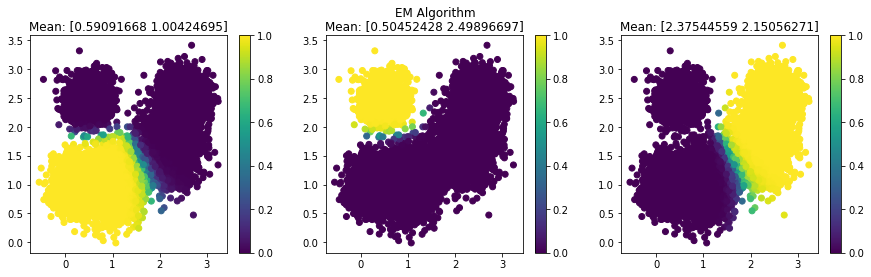

In [147]:
## Plotting Routine
fig = plt.figure(figsize=(15, 4))
plt.suptitle('EM Algorithm')
for i in range(NumComponents):
    ax = fig.add_subplot(1,NumComponents,i+1)
    p1 = ax.scatter(X[:,0], X[:,1], c=pZ_X[:,i]) 
    ax.set_title('Mean: '+ str(EM_Means[i,:]))
    fig.colorbar(p1, ax=ax);

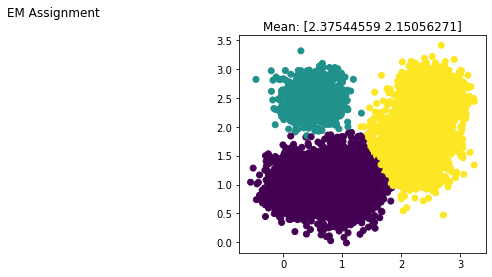

In [148]:
#Assigns each points to a class for coloring purposes
X_k = np.argmax(pZ_X, axis=1)
fig = plt.figure(figsize=(15,4))
plt.suptitle('EM Assignment')
ax = fig.add_subplot(1,NumComponents,i+1)
p1 = ax.scatter(X[:,0], X[:,1], c=X_k)
ax.set_title('Mean: ' + str(EM_Means[i,:]));

In [149]:
#Test silhouette score for a couple different K values that could be plausible (determined visually)
for i in range(2,6):
    _,_,_,pZ_K = EM_GaussianMixture(X, i)
    X_k = np.argmax(pZ_K, axis=1)
    print('K=', i, ":", silhouette_score(X, X_k))
    print()

t =  67 : 	 8.394036988639345e-05
K= 2 : 0.592068748661983

t =  31 : 	 8.595934261661399e-05
K= 3 : 0.6088873911049838

t =  100 : 	 0.00012923373837001083
K= 4 : 0.5440506754241186

t =  92 : 	 9.83697319066946e-05
K= 5 : 0.5060246667403728



1)There are 3 mixture components found in the data.

2)I ran the model for different K values and stuck with the one that captured the nature of the data the best. Since I have the visualization of the output at my disposal, I was able to determine the best K value visually. I knew the value was at very least 2 and at very most 6 so I tested all the those values. K=2 was clearly not capturing the nature of the data as the clump of points seperate from the rest as one cluster. K=4 also wasn't capturing the nature as well as K=3 as there was a band of points in the larger clump being assigned to a different class than the rest. An argument can be made for K=4, but K=3 captures the nature of the data the best.

Along with the visual analysis, I ran a silhouette score provided by sklearn to determine the best K value. The result is above. With a silhouette score, the closer the output is to 1 the better the K value. With this metric, K=3 is the closest value to 1.

In [13]:
#3)
print('The estimate for the mixture components is k = ', NumComponents)
for i in range(NumComponents):
    print('Class ', i+1, ": ")
    print('   Mean: ', EM_Means[i])
    print('   Covariance: ')
    print(EM_Sigs[:,:,i])
    print('   Pi: ', EM_Ps[i])
    print()

The estimate for the mixture components is k =  3
Class  1 : 
   Mean:  [0.590914   1.00424602]
   Covariance: 
[[0.21710489 0.00379946]
 [0.00379946 0.07325614]]
   Pi:  0.44227729577782976

Class  2 : 
   Mean:  [2.37544383 2.15056072]
   Covariance: 
[[0.09015743 0.05388296]
 [0.05388296 0.23091321]]
   Pi:  0.45058784361900905

Class  3 : 
   Mean:  [0.50452437 2.49896671]
   Covariance: 
[[ 0.06079308 -0.00014106]
 [-0.00014106  0.05026441]]
   Pi:  0.10713486060316116



# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.